In [1]:
import os
num_threads = "4"
os.environ["OMP_NUM_THREADS"] = num_threads
os.environ["OPENBLAS_NUM_THREADS"] = num_threads
os.environ["MKL_NUM_THREADS"] = num_threads
os.environ["VECLIB_MAXIMUM_THREADS"] = num_threads
os.environ["NUMEXPR_NUM_THREADS"] = num_threads

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy as sp
import sys
sys.path.append("../../src")
import importlib
import matplotlib.pyplot as plt
from sklearn import linear_model
import dcor
import torchsde
import pandas as pd
from torchdiffeq import odeint
import sklearn as sk
from sklearn import preprocessing
torch.set_default_dtype(torch.float32)

In [3]:
data = torch.load("data_cellcycle_pca.pkl", weights_only=False)
_idx = np.argsort(data['t_idx'])
data['x']=data['x'][_idx]
data['v']=data['v'][_idx]
data['t_idx'] = data['t_idx'][_idx]

In [4]:
d = data['x'].shape[-1]
T = len(np.unique(data['t_idx']))
ts = np.sort(np.unique(data['t_idx'])) / (T-1)

import fm
from tqdm import tqdm
import copy

scale_factors = torch.linspace(0, 100, 11)
otfms = [fm.LinearEntropicOTFM(data['x'], 
                      data['t_idx'], 
                      ts = ts,
                      sigma = 0.5,
                      A = data['A'] * s,
                      mu = data['mu'],
                      T = T,
                      dim = d,
                      device = torch.device('cpu')
                  )  for s in tqdm(scale_factors)]

/home/stephenz/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
  0%|                                                                                                                                                                                                                                                                                                                                                | 0/11 [00:00<?, ?it/s]/data/gpfs/projects/punim0638/stephenz/envs/lfm/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:1330: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

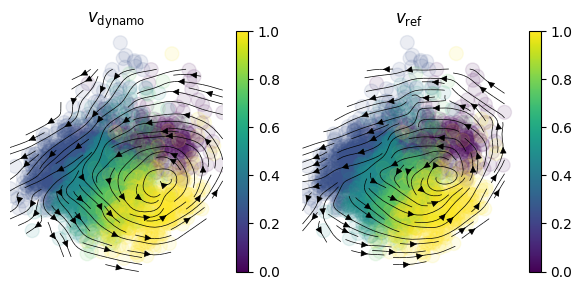

In [5]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np

def plot_stream_vectorfield(x, v, ax = None, x_min = None, x_max = None, y_min = None, y_max = None, **kwargs):
    x_min = x[:, 0].min() if x_min is None else x_min
    x_max = x[:, 0].max() if x_max is None else x_max
    y_min = x[:, 0].min() if y_min is None else y_min
    y_max = x[:, 0].max() if y_max is None else y_max
    _x, _y = np.meshgrid(np.linspace(x_min, x_max, 15), np.linspace(y_min, y_max, 15))
    _u = griddata((x[:, 0], x[:, 1]), v[:, 0], (_x, _y), method='linear', fill_value = 0)
    _v = griddata((x[:, 0], x[:, 1]), v[:, 1], (_x, _y), method='linear', fill_value = 0)
    if ax is None:
        plt.streamplot(_x, _y, _u, _v, **kwargs)
    else:
        ax.streamplot(_x, _y, _u, _v, **kwargs)

plt.figure(figsize = (6, 3))
plt.subplot(1, 2, 1)
v_ref = (data['x'] - data['mu']) @ data['A'].T
plt.scatter(data['x'][:, 0], data['x'][:, 1], c = data['t_idx'], alpha = 0.1, s = 100, rasterized = True);
plot_stream_vectorfield(data['x'][:, range(2)], data['v'][:, range(2)], color = 'k', linewidth = 0.5)
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.axis('off')
plt.colorbar()
plt.title("$v_{\\rm{dynamo}}$")
plt.subplot(1, 2, 2)
v_ref = (data['x'] - data['mu']) @ data['A'].T
plt.scatter(data['x'][:, 0], data['x'][:, 1], c = data['t_idx'], alpha = 0.1, s = 100, rasterized = True);
plot_stream_vectorfield(data['x'][:, range(2)], v_ref[:, range(2)], color = 'k', linewidth = 0.5)
plt.title("$v_{\\rm{ref}}$")
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.axis('off')
plt.colorbar()
plt.tight_layout()
# plt.savefig("../../figures/cellcycle_pca_vf.pdf", dpi = 300)

In [6]:
# Try Gaussian approximation
Xs = [data['x'][data['t_idx'] == i] for i in range(T)]
means = [torch.mean(x, 0) for x in Xs]
covs = [torch.cov(x.T) for x in Xs]
otfm = otfms[5]
j, offset = 0, 4
res = {}
for s in tqdm(scale_factors):
    _otfm = fm.LinearEntropicOTFM(otfm.x, 
                          otfm.t_idx, 
                          ts = otfm.ts,
                          sigma = otfm.sigma * offset**0.5,
                          A = data['A'] * offset * s,
                          mu = otfm.mu,
                          T = otfm.T,
                          dim = otfm.dim,
                          device = otfm.device
                      )
    gsb = fm.GaussianOUSB(_otfm.bm, _otfm)
    mean0, mean1 = means[j], means[j+offset]
    var0, var1 = covs[j], covs[j+offset]
    sb_means, sb_vars, S_t, d_sb_means = gsb.evaluate(torch.tensor(ts).float(), mean0, mean1, var0, var1)
    res[s.item()] = [fm.bures_wasserstein(sb_means[i].squeeze(), means[i], sb_vars[i], covs[i]).item() for i in range(T)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:11<00:00,  1.05s/it]


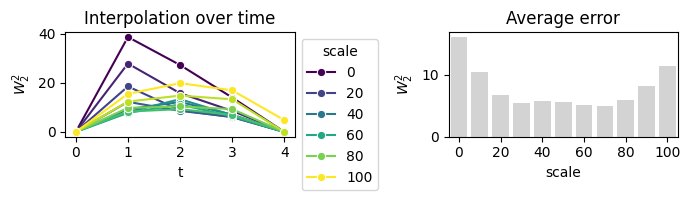

In [7]:
import seaborn as sb
df = pd.DataFrame(res)
plt.figure(figsize = (7, 2))
plt.subplot(1, 2, 1)
plt.title("Interpolation over time")
_df = df.reset_index().melt(id_vars = 'index', value_vars = df.columns).rename(columns={'index' : 't', 'variable' : 'scale'}, inplace = False)
ax=sb.lineplot(_df, x = "t", y = "value", hue = "scale", palette = "viridis", marker = "o")
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.ylabel("$W_2^2$")
plt.subplot(1, 2, 2)
sb.barplot(df.mean(0), color = 'lightgrey')
plt.xticks(ticks = range(len(scale_factors))[::2], labels = scale_factors.int().numpy()[::2])
plt.ylabel("$W_2^2$")
plt.xlabel("scale")
plt.title("Average error")
plt.tight_layout()
# plt.savefig("../../figures/cellcycle_interp_error.pdf")

In [10]:
# Train flow matching
hidden_sizes_score = [64, 64, 64]
hidden_sizes_flow = [64, 64, 64]

models = {}

for s in [0, 50.0]:
    print(f"Training OT-FM for s = {s}")
    otfm = otfms[np.where(scale_factors == s)[0][0]]
    s_model = fm.MLP(d = d, hidden_sizes = hidden_sizes_score, time_varying=True, activation = torch.nn.ReLU)
    v_model = fm.MLP(d = d, hidden_sizes = hidden_sizes_flow, time_varying=True, activation = torch.nn.ReLU)
    optim = torch.optim.AdamW(list(s_model.parameters()) + list(v_model.parameters()), 1e-2)
    alpha = 0.5
    for i in tqdm(range(1_000)):
        _x, _s, _u, _t, _t_orig = otfm.sample_bridges_flows(batch_size = 64)
        optim.zero_grad()
        s_fit = s_model(_t, _x)
        v_fit = v_model(_t, _x)
        L_score = torch.mean(((_t_orig * (1-_t_orig)) * (s_fit - _s))**2) * otfm.sigma**2
        L_flow = torch.mean((_t_orig * (1-_t_orig)*(v_fit - _u))**2)
        # L_flow = torch.mean((v_fit - _u)**2)
        L = (1-alpha)*L_score + alpha*L_flow
        if i % 1000 == 0:
            print(L_score.item(), L_flow.item())
        L.backward()
        optim.step()
    models[s] = (s_model, v_model)

Training OT-FM for s = 0


  0%|█▋                                                                                                                                                                                                                                                                                                                                    | 5/1000 [00:00<00:21, 47.27it/s]

0.6402176022529602 0.8446426391601562


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.73it/s]


Training OT-FM for s = 50.0


  0%|▋                                                                                                                                                                                                                                                                                                                                     | 2/1000 [00:00<00:54, 18.23it/s]

0.65667325258255 0.9490300416946411


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.85it/s]


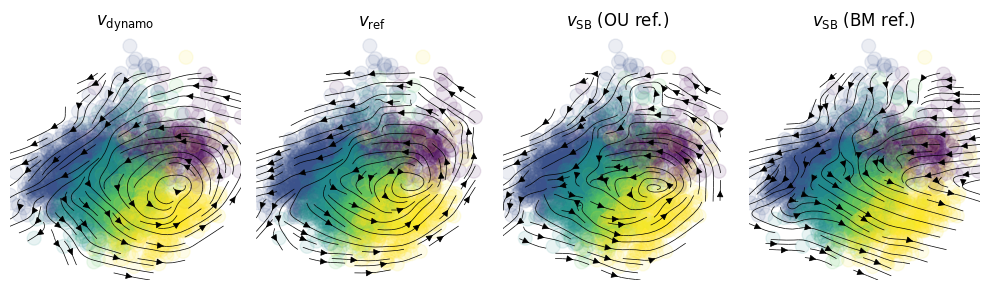

In [11]:
plt.figure(figsize = (10, 3))
plt.subplot(1, 4, 1)
v_ref = (data['x'] - data['mu']) @ data['A'].T
plt.scatter(data['x'][:, 0], data['x'][:, 1], c = data['t_idx'], alpha = 0.1, s = 100, rasterized = True);
plot_stream_vectorfield(data['x'][:, range(2)], data['v'][:, range(2)], color = 'k', linewidth = 0.5)
plt.xlabel("PCA1"); plt.ylabel("PCA2"); plt.axis('off')
# plt.colorbar()

plt.title("$v_{\\rm{dynamo}}$")
plt.subplot(1, 4, 2)
v_ref = (data['x'] - data['mu']) @ data['A'].T
plt.scatter(data['x'][:, 0], data['x'][:, 1], c = data['t_idx'], alpha = 0.1, s = 100, rasterized = True);
plot_stream_vectorfield(data['x'][:, range(2)], v_ref[:, range(2)], color = 'k', linewidth = 0.5)
plt.title("$v_{\\rm{ref}}$")
plt.xlabel("PCA1"); plt.ylabel("PCA2"); plt.axis('off')
# plt.colorbar()

plt.subplot(1, 4, 4)
(v_model, s_model), sigma = models[0.], otfm.sigma
sde = fm.SDE(lambda t, x: v_model(t, x) + sigma**2 / 2 * s_model(t, x), sigma)
with torch.no_grad():
    v_sb = torch.vstack([sde.f(torch.scalar_tensor(t), data['x'][data['t_idx'] == i, ...]) for i, t in enumerate(ts)])
plt.scatter(data['x'][:, 0], data['x'][:, 1], c = data['t_idx'], alpha = 0.1, s = 100, rasterized = True);
plot_stream_vectorfield(data['x'][:, range(2)], v_sb[:, range(2)], color = 'k', linewidth = 0.5)
plt.title("$v_{\\rm{SB}}$ (BM ref.)")
plt.xlabel("PCA1"); plt.ylabel("PCA2"); plt.axis('off')
# plt.colorbar()

plt.subplot(1, 4, 3)
(v_model, s_model), sigma = models[50.], otfm.sigma
sde = fm.SDE(lambda t, x: v_model(t, x) + sigma**2 / 2 * s_model(t, x), sigma)
with torch.no_grad():
    v_sb_ou = torch.vstack([sde.f(torch.scalar_tensor(t), data['x'][data['t_idx'] == i, ...]) for i, t in enumerate(ts)])
plt.scatter(data['x'][:, 0], data['x'][:, 1], c = data['t_idx'], alpha = 0.1, s = 100, rasterized = True);
plot_stream_vectorfield(data['x'][:, range(2)], v_sb_ou[:, range(2)], color = 'k', linewidth = 0.5)
plt.title("$v_{\\rm{SB}}$ (OU ref.)")
plt.xlabel("PCA1"); plt.ylabel("PCA2"); plt.axis('off')
# plt.colorbar()
plt.tight_layout()
# plt.savefig("../../figures/cellcycle_pca_vf_with_fm.pdf", dpi = 300)